# Agglomerative Hierarchical Clustering On Ocean Altimetry Data

The following code uses agglomerative hierarchical clustering on ocean altimetry data, with the goal of returning some regions of covariability. This code uses AVISO altimetry data but can be used on any gridded nc data. 

## Packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import pandas as pd
import copy
import cartopy.crs as ccrs
from sklearn.neighbors import kneighbors_graph
import itertools
from geopy import distance
import cartopy.feature as cfeature
from scipy.signal import butter, filtfilt
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
from sklearn.metrics.pairwise import haversine_distances

from math import radians

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
from cmip_basins.basins import generate_basin_codes
from statsmodels.tools.eval_measures import aic
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy import stats
from scipy.signal import butter, filtfilt


## Inputs

In [44]:
saved_distance_matrix_bool = False
saved_distance_matrix_file_path = 'na'

#file_path = '/work/t1a/AVISO_global_1993to2023_sla_monthly'
file_path = '/work/jet/sea_level_covariability/data/zarr/AVISO_global_1993to2023_sla_monthly/'
#model_path = '/work/jet/sea_level_covariability/data/zarr/CM4_historical_251_global_1850to2014_sla_monthly'

start_year, end_year = 1993, 2014

smoothing_std = 4

longitude_min, longitude_max = 0, 360
latitude_min, latitude_max = -90, 90

coarsen_factor_longitude, coarsen_factor_latitude = 4, 4

#rolling_window_ar = [12]
rolling_window = 24

#a_const_dist_matrix, a_str = (2*38.92081439196014**2), 2100
a_const_dist_matrix, a_str = (2*46.51927**2), 3000
#a_const_dist_matrix, a_str = (2*32.89409**2), 1500
#a_const_dist_matrix, a_str = (2*56.97423**2), 4500
#a_const_dist_matrix, a_str = (2*18.99141**2), 500
num_clusters_arr_silo = np.arange(2,50)

num_clusters_arr = np.arange(6, 7)
num_clusters = num_clusters_arr[0]
linkage_type = 'average'
linkage_ar = ['average', 'ward', 'complete', 'single']
geographic_distance, saved_geo_matrix_bool = '/work/t1a/geographic_distance_matrix_5x5_20_rolling_5.npy', False
ds = xr.open_zarr(file_path)
cmap_ar_div = []
matplot_color_array = ['forestgreen','gold', 'turquoise', 'orange', 'dodgerblue', 'mediumvioletred', 'peru', 'blue', 'indigo', 'violet', 'lightgreen', 'crimson', 'maroon', 'lightsalmon', 'powderblue']

for color_matplot in (matplot_color_array[0:num_clusters]):
    div_color = sns.light_palette(color_matplot, as_cmap=True)
    cmap_ar_div.append(div_color)

order_var = 4

In [45]:
distance_halves = np.arange(3000, 3100, 100)
a_const_dist_matrix_ar = []
for D in distance_halves:
    a = np.sqrt(-D/(2*np.log(.5)))
    print(str(D) + ':' + str(a))
    a_const_dist_matrix_ar.append(a)


3000:46.51927085986457


## Low pass Vectorized Function

In [46]:
def butter_lowpass_filter(data, cutoff_period, fs, order=order_var, pass_amplitude=0.9):
    """
    Applies a Butterworth low-pass filter to the data.
    
    Parameters:
    data (array-like): The data to be filtered.
    cutoff_period (int): The period (in months) of the low-pass filter.
    fs (int): The sampling frequency, default is 1 (monthly data).
    order (int): The order of the Butterworth filter.
    pass_amplitude (float): The amplitude that should be passed at the cutoff period (default is 0.9).
    
    Returns:
    filtered_data (array-like): The filtered data.
    """
    # Calculate the Nyquist frequency
    nyquist = 0.5 * fs
    
    # Convert the cutoff period to a frequency
    target_freq = 1.0 / cutoff_period
    
    # Adjust the cutoff frequency to account for 90% pass amplitude
    # Approximate this by multiplying target frequency by 1.2 (or adjust factor as needed)
    adjusted_cutoff = target_freq * 1.2
    
    # Normalize the adjusted cutoff frequency
    normal_cutoff = adjusted_cutoff / nyquist
    
    # Design Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    # Apply the filter to the data using filtfilt (to avoid phase distortion)
    return filtfilt(b, a, data)

def apply_lowpass_on_time(da, cutoff_period, fs=1, order=order_var, pass_amplitude=0.9):
    """
    Apply Butterworth low-pass filter on an xarray DataArray along the time dimension.
    
    Parameters:
    da (xarray.DataArray): The data to filter (1D or more, with 'time' as a dimension).
    cutoff_period (int): The period (in months) of the low-pass filter (e.g., 24 for 24-month low-pass).
    fs (int): Sampling frequency, default is 1 for monthly data.
    order (int): The order of the Butterworth filter.
    pass_amplitude (float): The amplitude to pass at the cutoff period (default is 90%).
    
    Returns:
    xarray.DataArray: The filtered DataArray.
    """
    # Create a wrapper function for the filtering, handling constants like cutoff and fs
    def filter_wrapper(data):
        return butter_lowpass_filter(data, cutoff_period=cutoff_period, fs=fs, order=order, pass_amplitude=pass_amplitude)
    
    # Apply the filter using apply_ufunc, vectorized along 'time' dimension
    filtered = xr.apply_ufunc(
        filter_wrapper,
        da,
        vectorize=True,
        input_core_dims=[['time']],  # Apply along 'time' dimension
        output_core_dims=[['time']],
        dask="parallelized",  # Parallelize if using dask
        output_dtypes=[da.dtype]
    )
    return filtered


In [47]:
def weighted_mean(data, weights):
    """
    Calculate the weighted mean of an xarray DataArray.

    Parameters:
    data (xarray.DataArray): The data to average.
    weights (xarray.DataArray): The weights to apply, with the same dimensions as `data`.

    Returns:
    xarray.DataArray: The weighted mean of the input data.
    """
    # Multiply data by weights
    weighted_data = data * weights
    
    # Sum weighted data and weights
    sum_weighted_data = weighted_data.sum(dim=['latitude', 'longitude'])
    sum_weights = weights.sum(dim=['latitude', 'longitude'])
    
    # Compute weighted mean
    weighted_mean = sum_weighted_data / sum_weights
    
    return weighted_mean

#weighted_mean = weighted_mean(ds.sla, ds.areacello)


## Preprocessing

In [48]:
def load_clean_data():
    ds = xr.open_zarr(file_path)
    ds = ds.rename({f'{list(ds.dims)[1]}': 'longitude', f'{list(ds.dims)[0]}': 'latitude'})
    basincodes = generate_basin_codes(ds, lon="geolon", lat="geolat", mask="wet")
    basincodes_aviso_mask = (basincodes == 9) | (basincodes == 10) | (basincodes == 9) | (basincodes == 8) | (basincodes == 7) | (basincodes == 6)
    ds = ds.where(~basincodes_aviso_mask).copy(deep=True)
    
    subset = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
    subset['sla'] = subset['sla'] - subset.sla.mean('time')
    subset.load()
    #da_gm = subset.sla.weighted(subset.areacello * subset.wet).mean(('latitude', 'longitude'))
    #subset['sla'] = subset.sla - da_gm
    
    #weights = np.cos(np.deg2rad(subset.latitude))
    #sla_weighted = subset.sla.weighted(weights)
    #global_mean_sla_to_remove = sla_weighted.mean(dim=("longitude", "latitude"))
    
    #subset['sla'] = (subset['sla'] - global_mean_sla_to_remove).copy(deep=True)
    kernel = Gaussian2DKernel(x_stddev=smoothing_std)
    def smooth_time_slice(time_slice):
        return convolve_fft(time_slice, kernel)
    
    # Apply the smoothing function across the 'time' dimension
    smoothed_sla = xr.apply_ufunc(
        smooth_time_slice,
        subset.sla,
        input_core_dims=[['latitude', 'longitude']],
        output_core_dims=[['latitude', 'longitude']],
        vectorize=True
    )

    # Update the dataset with smoothed values
    subset['sla'] = smoothed_sla
        # Coarsen data, change boundaries, and mask the dry values #####################################################################
    subset_Coarse = subset.coarsen(longitude=coarsen_factor_longitude, latitude=coarsen_factor_latitude).mean().copy(deep=True)

    #subset_Coarse_lat_lon_slice = subset_Coarse.sel(longitude=slice(longitude_min, longitude_max), latitude=slice(latitude_min, latitude_max))
    subset_Coarse_lat_lon_slice = subset_Coarse.copy(deep=True)
    subset_Coarse_lat_lon_slice['wet'] = subset_Coarse_lat_lon_slice['wet'].round()
    mask = subset_Coarse_lat_lon_slice['wet'] == 1
    subset_Coarse_lat_lon_slice = subset_Coarse_lat_lon_slice.where(mask)
    
    # Low pass filter code Here (i.e. temporal smoothing)  #######################################################################
    subset_Coarse_lat_lon_slice['sla'] = apply_lowpass_on_time(
        subset_Coarse_lat_lon_slice['sla'], 
        cutoff_period=rolling_window
    ).copy(deep=True)
    return subset_Coarse_lat_lon_slice

subset_Coarse_lat_lon_slice = load_clean_data()
subset_Coarse_lat_lon_slice_initeration = subset_Coarse_lat_lon_slice.sla
# Keys for indexing in the dataframe ###################################################################################

ds_subset = subset_Coarse_lat_lon_slice_initeration.to_dataframe()
ds_dataframe_nonnan = ds_subset.dropna()

grouped_df = ds_dataframe_nonnan.groupby(['latitude', 'longitude'])
grouped_by_longitude_latitude = grouped_df.groups
keys_for_indexing = list(grouped_by_longitude_latitude.keys())

# Distance matrix ################################################################################################################## 

n = len(grouped_by_longitude_latitude)
comparison_matrix = np.zeros((n, n), dtype=float)


geographic_matrix = (haversine_distances(np.radians(keys_for_indexing)) * 6371)
da_flat = subset_Coarse_lat_lon_slice_initeration.stack(location=('latitude', 'longitude')).transpose('location', 'time')
da_flattened = da_flat.dropna(dim='location', how='all')
r = da_flattened.to_pandas().T.corr(method='pearson')


## Clustering 

In [ ]:
for linkage_type in ['average', 'weighted']:
    for a_str_it, a_const_dist_matrix in enumerate(a_const_dist_matrix_ar): 
        a_constant = (2*a_const_dist_matrix**2)
        comparison_matrix = 1-np.exp((-geographic_matrix)/(a_constant))*r
        
        nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
        nan_dataset_to_fill['sla'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['sla'].coords, 
                                    dims=nan_dataset_to_fill['sla'].dims)
        nan_dataset_to_fill = nan_dataset_to_fill.mean(dim='time')
    
        for num_clusters_range_it in num_clusters_arr:
            
            distance_matrix = comparison_matrix
            
            linkage_matrix = linkage(distance_matrix, method=linkage_type)
            
            # Extract the cluster labels
            cluster_labels = fcluster(linkage_matrix, num_clusters_range_it, criterion='maxclust')
            
            unique_labels = np.unique(cluster_labels)
            list_to_array_slicing = np.array(keys_for_indexing)
            
            for label in unique_labels:
                cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
                # in the code below when we index using 0 and 1 that is the array of the longitude and latitude coords. We must now put these into an xarray dataset.
                group_longitude = list_to_array_slicing[cluster_points, 1]
                group_latitude = list_to_array_slicing[cluster_points, 0]
            
                for point_iterator in range(len(group_latitude)):
                    nan_dataset_to_fill.loc[{'longitude': group_longitude[point_iterator], 'latitude': group_latitude[point_iterator]}] = label
            
            from matplotlib.colors import ListedColormap, BoundaryNorm
            
            # Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
            sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
            center_value_longitude = 180
            sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude
            
            # Define the number of discrete values (clusters) you have
            
            # Create a discrete colormap
            cmap = LinearSegmentedColormap.from_list("saturated_values", matplot_color_array[0:num_clusters])
        
            bounds = np.arange(1, num_clusters_range_it + 2) - .5
            norm = BoundaryNorm(bounds, cmap.N)
            
            # Plotting the cluster map
            projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})
            
            # Plot the data
            sla_dataset_to_plot.sla.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)
            
            # Add title and extent
            ax.set_title(f'a_{distance_halves[a_str_it]}, {start_year}_{end_year}_{linkage_type}_{rolling_window}mnth', fontsize=14)
            ax.set_extent([-180, 180, -90, 90], crs=projection)
            
            # Add coastlines and features
            ax.coastlines(transform=projection)
            ax.add_feature(cfeature.LAND, zorder=10, color='black')
            ax.add_feature(cfeature.OCEAN, color='#554645')
            
            # Create colorbar
            cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_ticks(np.arange(1, num_clusters_range_it + 1))
            cbar.set_ticklabels(np.arange(1, num_clusters_range_it + 1))
            
            # Save the figure
            plt.savefig(f'aviso_maps_recreation/2_high_resolution/sla_mss_normed_{linkage_type}_linkage_{num_clusters_range_it}_clusters_a_{distance_halves[a_str_it]}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}_order_{order_var}.png')
        

/vftmp/Theo.Avila/pid220976/ipykernel_45916/1773027375.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)


##### vary clust

In [108]:
for num_clusters_range_it in num_clusters_arr[:1]:

    nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
    nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                                dims=nan_dataset_to_fill['zos'].dims)
    nan_dataset_to_fill = nan_dataset_to_fill.mean(dim='time')
    
    comparison_matrix = 1-np.exp((-geographic_matrix)/(a_const_dist_matrix))*r
    distance_matrix = comparison_matrix
    
    linkage_matrix = linkage(distance_matrix, method=linkage_type)
    
    # Extract the cluster labels
    cluster_labels = fcluster(linkage_matrix, num_clusters_range_it, criterion='maxclust')
    
    unique_labels = np.unique(cluster_labels)
    list_to_array_slicing = np.array(keys_for_indexing)
    
    for label in unique_labels:
        cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
        # in the code below when we index using 0 and 1 that is the array of the longitude and latitude coords. We must now put these into an xarray dataset.
        group_longitude = list_to_array_slicing[cluster_points, 1]
        group_latitude = list_to_array_slicing[cluster_points, 0]
    
        for point_iterator in range(len(group_latitude)):
            nan_dataset_to_fill.loc[{'longitude': group_longitude[point_iterator], 'latitude': group_latitude[point_iterator]}] = label
    
    from matplotlib.colors import ListedColormap, BoundaryNorm
    
    # Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
    sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
    center_value_longitude = 180
    sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude
    
    # Define the number of discrete values (clusters) you have
    
    # Create a discrete colormap
    cmap = LinearSegmentedColormap.from_list("saturated_values", matplot_color_array[0:num_clusters])

    bounds = np.arange(1, num_clusters_range_it + 2) - .5
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Plotting the cluster map
    projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})
    
    # Plot the data
    sla_dataset_to_plot.zos.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)
    
    # Add title and extent
    ax.set_title(f' AVISO Clustering SLA {start_year} {end_year}', fontsize=14)
    ax.set_extent([-180, 180, -90, 90], crs=projection)
    
    # Add coastlines and features
    ax.coastlines(transform=projection)
    ax.add_feature(cfeature.LAND, zorder=10, color='black')
    ax.add_feature(cfeature.OCEAN, color='#554645')
    
    # Create colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.75)
    cbar.set_ticks(np.arange(1, num_clusters_range_it + 1))
    cbar.set_ticklabels(np.arange(1, num_clusters_range_it + 1))
    
    # Save the figure
    #plt.savefig(f'presentation_images/aviso/normalized_after/aviso_zosminmss_normed_{linkage_type}_linkage_{num_clusters_range_it}_clusters_a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')
    

KeyError: "No variable named 'zos'. Variables on the dataset include ['geolat', 'geolon', 'lon', 'sla', 'latitude', 'longitude', 'time']"

### Sklearn Tests
- calinski harabasz, silhouette, dave_bouldin

In [98]:
silo_to_plot_ch = []
silo_to_plot = []
db_score = []

for num_clusters_silo in num_clusters_arr_silo:
    distance_matrix = comparison_matrix
    
    linkage_matrix = linkage(distance_matrix, method=linkage_type)
    cluster_labels = fcluster(linkage_matrix, num_clusters_silo, criterion='maxclust')

    # Calinksi Harabasz Score
    ch_avg = calinski_harabasz_score(distance_matrix, cluster_labels)
    silo_to_plot_ch.append(ch_avg)

    # Silhouette average
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silo_to_plot.append(silhouette_avg)

    dave_bould = davies_bouldin_score(distance_matrix, cluster_labels)
    db_score.append(dave_bould)

/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)


#### Plotting Metrics

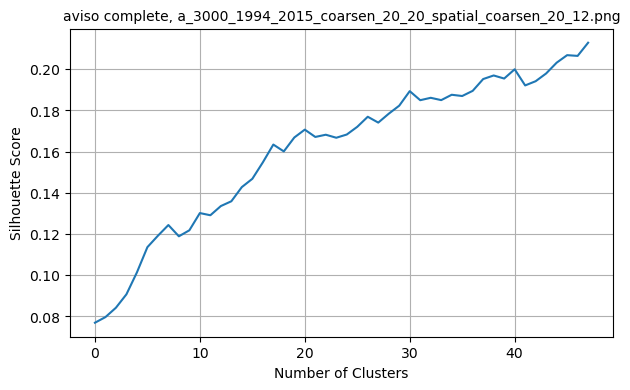

In [87]:
# Silhouette Plot
plt.plot(silo_to_plot)
plt.title(f'aviso {linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(7, 4) 
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
#plt.ylim(0.05, .275)  
plt.grid(True)

plt.savefig(f'aviso_maps/15_opt_clust_num/15_silo/avi_silo_{linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

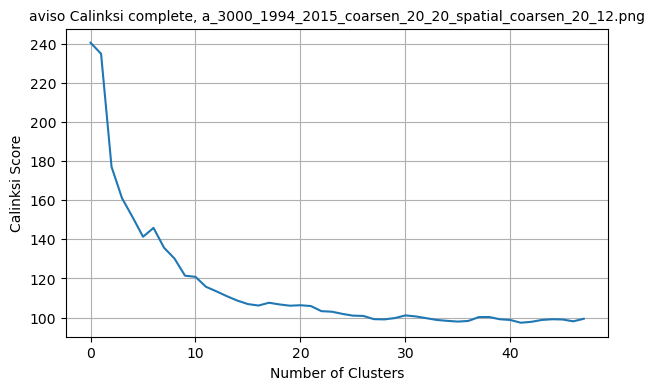

In [88]:
# Calinski Test
plt.plot(silo_to_plot_ch)
plt.title(f'aviso Calinksi {linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(7, 4) 
plt.xlabel('Number of Clusters')
plt.ylabel('Calinksi Score')
#plt.ylim(0.05, .275)  
plt.grid(True)

plt.savefig(f'aviso_maps/15_opt_clust_num/15_calinski/avi_calinksi_{linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

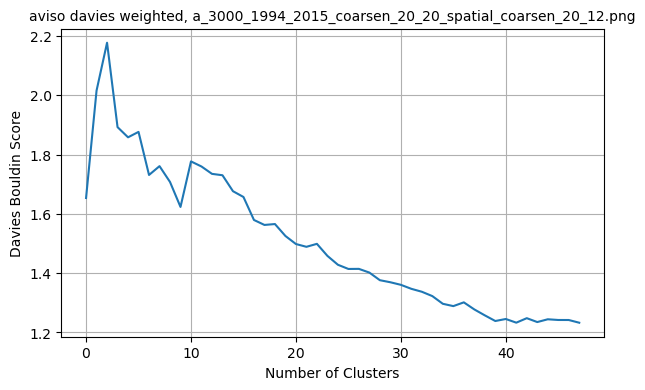

In [100]:
# Davies Bouldin Test
plt.plot(db_score)
plt.title(f'aviso davies {linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(7, 4) 
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
#plt.ylim(0.05, .275)  
plt.grid(True)

plt.savefig(f'aviso_maps/15_opt_clust_num/15_db/avi_db_{linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

### Dendrograms

/vftmp/Theo.Avila/pid42932/ipykernel_86800/99550908.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend))


Text(0.5, 1.0, 'Dendrogram AVISO Satellite Data')

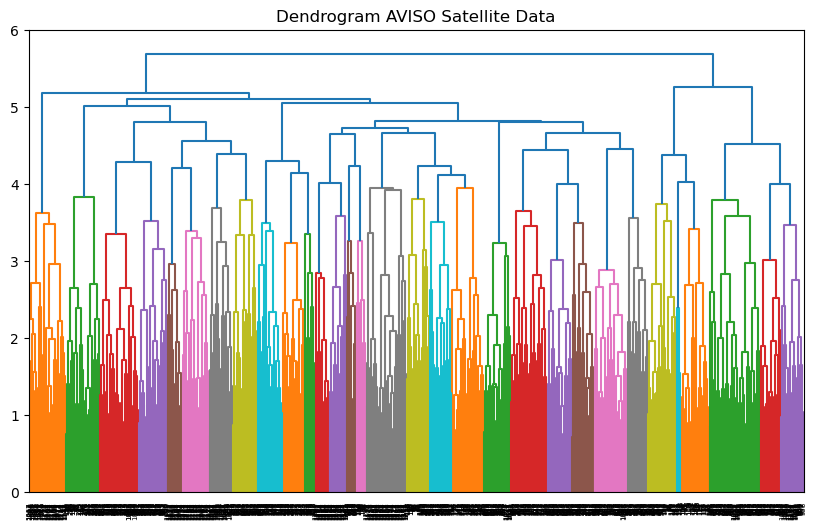

In [6]:
method_dend = 'average'

# Generate the dendrogram
dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend))
plt.ylim(0, 6)

# Change the figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # Set the desired width and height

# Add a title
plt.title(f"Dendrogram AVISO Satellite Data")

# Show the dendrogram
#plt.savefig(f'presentation_images/aviso/dendrogram_non_trunc{method_dend}_yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window}.png')

### Masking for Aggregate Cluster TS

#### Sea Level Anamoly Plots

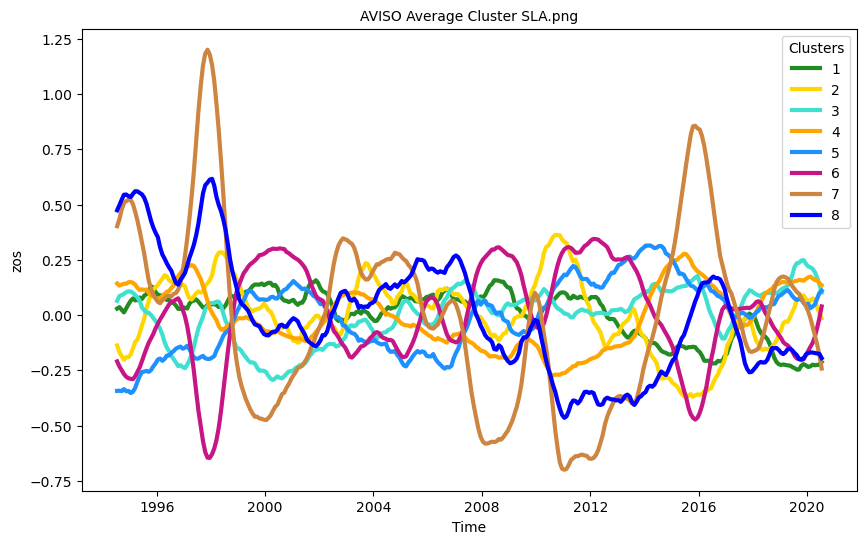

In [6]:
mask = nan_dataset_to_fill.copy(deep=True)

cmap = LinearSegmentedColormap.from_list("saturated_values", matplot_color_array[0:num_clusters])
#figure = plt.figure(figsize=(10, 6))

# Grouping each cluster and plotting

each_cluster_dataset_true, each_cluster_dataset_false = [], []
cluster_time_series_arr = []
idx = 0
for cluster_val in unique_labels:

    # Creating boolean based off of unique label, then applying so I have just the values for each cluster, could add to an array in order iterate through the others for covariance.
    boolean_mask_cluster = mask['zos'] == cluster_val
    cluster_i_masked_true = subset_Coarse_lat_lon_slice.where(boolean_mask_cluster).copy(deep=True)
    cluster_i_masked_false = subset_Coarse_lat_lon_slice.where(~boolean_mask_cluster).copy(deep=True)

    each_cluster_dataset_true.append(cluster_i_masked_true)
    each_cluster_dataset_false.append(cluster_i_masked_false)
Organizing
    # Mean of each cluster in time from original. 
    cluster_i_masked_mean = cluster_i_masked_true.mean(dim=['longitude', 'latitude'])
    cluster_i_masked_mean.zos.plot(label=f'{cluster_val}', color=matplot_color_array[idx], linewidth=3)
    cluster_time_series_arr.append(cluster_i_masked_mean.zos)
    idx += 1
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend(title="Clusters")
plt.title(f'AVISO Average Cluster SLA.png', fontsize=10)
#plt.savefig(f'presentation_images/ts_aviso_zosminmss_norm_{linkage_type}_linkage_{num_clusters_range_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}')
#plt.legend()
plt.show()

#### Correlation Grid for clusters

##### Loading climate indexes for correlation

In [74]:
basepath = '/work/Theo.Avila/0_climate_indices/'
index_file_paths = ['amo_monthly_10yrLP.data', 'nao_norm_nao_monthly_b5001_current_ascii.data', 'nina4_anom_enso.data', 
                    'oni_enso.data', 'pdo_timeseries_sstens.data', 'soi_enso.data','sam_new_1957_2007.data', 'npo.data']
index_names = ['amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'sam', 'npo']
index_values = [[], [], [], [], [], [], [], []]

for index_naming_it, index_path in enumerate(index_file_paths): 
    file_path = basepath + index_path
    print(index_names[index_naming_it])
    data_array = np.loadtxt(file_path)
    df_arr = pd.DataFrame(data_array.transpose())
    df = df_arr.iloc[1:, :]
    df.columns = list(range(int(df_arr[0][0]), int(df_arr[0][0]) + int(np.shape(df_arr)[1])))
    df = df.transpose().loc[start_year:end_year]
    df_new_years = np.reshape(df.values, (1, np.shape(df)[0] * np.shape(df)[1]))[0]
    
    data_array_index = xr.DataArray(df_new_years).rename(index_names[index_naming_it])
    data_array_index['dim_0'] = cluster_time_series_arr[0].time.values
    da_renamed = data_array_index.rename({'dim_0' : 'time'})
    index_values[index_naming_it] = da_renamed
    


amo
nao
enso4
oni
pdo
soi
sam
npo


In [75]:
# Adding indexes to array in order to plot correlation
for climate_mode in index_values:
    cluster_time_series_arr.append(climate_mode)
for i in range(len(cluster_time_series_arr)):
    cluster_time_series_arr[i] = cluster_time_series_arr[i].isel(time=slice(6, -5))

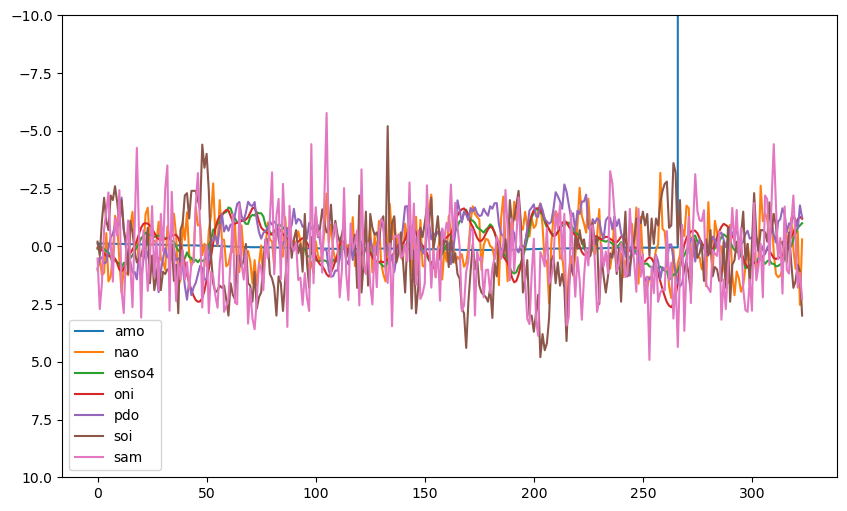

In [76]:

for climate_mode in index_values[:-1]:
    plt.plot(climate_mode,label=climate_mode.name)

plt.ylim(10, -10)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()

In [77]:
zero_matrix_for_ttest_corr = np.zeros((len(cluster_time_series_arr), len(cluster_time_series_arr)))
zero_matrix_for_ttest_pval = np.zeros((len(cluster_time_series_arr), len(cluster_time_series_arr)))

for i, pair1 in enumerate(cluster_time_series_arr):
    for j, pair2 in enumerate(cluster_time_series_arr):
        single_correlation, single_p_value = stats.pearsonr(pair1.values, pair2.values)
        zero_matrix_for_ttest_corr[i][j] = single_correlation
        zero_matrix_for_ttest_pval[i][j] = single_p_value

# mask for statistically insignificant p-values
zero_matrix_for_ttest_pval[np.tril_indices(zero_matrix_for_ttest_pval.shape[0], -1)] = np.nan
correlation_matrix_clusters_pd_p = pd.DataFrame(zero_matrix_for_ttest_pval)

##### Plotting Correlation Maps

In [9]:
zero_matrix_for_ttest_corr[np.tril_indices(zero_matrix_for_ttest_corr.shape[0], -1)] = np.nan
correlation_matrix_clusters_pd = pd.DataFrame(zero_matrix_for_ttest_corr)
correlation_matrix_clusters_pd.columns = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
correlation_matrix_clusters_pd.index = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
correlation_matrix_clusters_pd_p.columns = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
correlation_matrix_clusters_pd_p.index = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
extent_val = [.5, 18.5, 18.5, .5]
correlation_matrix_clusters_pd = correlation_matrix_clusters_pd.where(correlation_matrix_clusters_pd_p <= 0.05)
plt.imshow(correlation_matrix_clusters_pd, vmin=-1, vmax=1, extent = extent_val, cmap='coolwarm')
plt.xticks(ticks=np.arange(1, 19, 1), labels=correlation_matrix_clusters_pd.columns, rotation=90, ha='right')
plt.xlim(0.5, 18.5)
plt.yticks(ticks=np.arange(1, 19, 1), labels=correlation_matrix_clusters_pd.columns, ha='right')
plt.ylim(18.5, .5)

plt.xlabel('cluster number / modes')
plt.ylabel('cluster number / modes')
plt.title('AVISO sla cluster modes timeseries Correlation')
plt.colorbar()
#plt.savefig(f'aviso_maps/21_alltime/corr_map_aviso_zosminmss_norm_clim_modes{linkage_type}_linkage_{num_clusters_range_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

NameError: name 'zero_matrix_for_ttest_corr' is not defined

#### Volume redistribution per TM14 plots
$$
\text{rate of redistribution} = \frac{A_2}{A_T} \frac{d n_2}{d t} - \frac{A_1}{A_T} \frac{d n_1}{d t}
$$
$\text{in this case A is area of cluster and the derivative is the rate of change of sla}$

In [7]:
mask = nan_dataset_to_fill.copy(deep=True)

subtracted_redistribution_timeseries_arr = []
non_normalized_distribution = load_clean_data(False)
for i, cluster_val1 in enumerate(unique_labels):
    
    boolean_mask_cluster_1 = mask['zos'] == cluster_val1
    cluster_i_masked_1 = non_normalized_distribution.where(boolean_mask_cluster_1).copy(deep=True)
    area_1 = (cluster_i_masked_1['areacello'] * cluster_i_masked_1['wet']).mean(dim=['longitude', 'latitude'])
    sla_1 = area_1 * cluster_i_masked_1['zos']
    cluster_i_masked_mean_1 = sla_1.mean(dim=['longitude', 'latitude'])
    
    for j, iterative_cluster_val2 in enumerate(unique_labels):
        
        boolean_mask_cluster_2 = mask['zos'] == iterative_cluster_val2
        cluster_i_masked_2 = non_normalized_distribution.where(boolean_mask_cluster_2).copy(deep=True)
        area_2 = (cluster_i_masked_2['areacello'] * cluster_i_masked_2['wet']).mean(dim=['longitude', 'latitude'])
        sla_2 = area_2 * cluster_i_masked_2['zos']
        cluster_i_masked_mean_2 = sla_2.mean(dim=['longitude', 'latitude'])
        A_total = area_1 + area_2
        rate_of_redistribution = (area_2.values.item() / A_total.values.item()) * (np.gradient(cluster_i_masked_mean_2)) - \
                                    (area_1.values.item() / A_total.values.item()) * (np.gradient(cluster_i_masked_mean_1))
        rate_of_redistribution_smoothed = np.array(pd.DataFrame(rate_of_redistribution).rolling(window=rolling_window, center=True).mean())
        rate_of_redistribution_smoothed = np.reshape(rate_of_redistribution_smoothed, len(rate_of_redistribution_smoothed))
        subtracted_redistribution_timeseries_arr.append(rate_of_redistribution_smoothed)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

##### Correlation with climate modes for all points

In [8]:
basepath = '/work/Theo.Avila/0_climate_indices/'
index_file_paths = ['amo_monthly_10yr.data', 'nao_norm_nao_monthly_b5001_current_ascii.data', 'nina4_anom_enso.data', 
                    'oni_enso.data', 'soi_enso.data', 'pdo_timeseries_sstens.data', 'sam_new_1957_2007.data', 'npo_fixed.data']
index_names = ['amo', 'nao', 'enso4', 'oni', 'soi', 'pdo', 'sam', 'npo']
index_values = [[], [], [], [], [], [], [], []]

for index_naming_it, index_path in enumerate(index_file_paths): 
    file_path = basepath + index_path
    print(index_names[index_naming_it])
    if index_names[index_naming_it] == 'npo':
        data_array = np.loadtxt(file_path)
        df_arr = pd.DataFrame(data_array.transpose())

        column_arr_years = []
        for year_month_ in df_arr.loc[0]:
            year_npo = str(year_month_)[:4]
            month_npo = str(year_month_)[4:6]
            column_arr_years.append(str(year_npo))
        df_arr.columns = column_arr_years
        df_arr = df_arr.loc[1]
        df_arr = pd.DataFrame(df_arr).loc[str(start_year):str(end_year)]
        df_arr_smoothed = np.array(pd.DataFrame(df_new_years).rolling(window=rolling_window, center=True).mean())
        df_new_years_smoothed = np.reshape(np.array(df_arr_smoothed), len(df_arr_smoothed))
        df_new_years_delta = np.gradient(df_new_years_smoothed)
        
        df_new_years_delta_smoothed = np.array(pd.DataFrame(df_new_years_delta).rolling(window=rolling_window, center=True).mean())
        df_new_years_delta_smoothed_shaped = np.reshape(df_new_years_delta_smoothed, (len(df_new_years_delta_smoothed)))

        subtracted_redistribution_timeseries_arr.append(df_new_years_delta_smoothed_shaped)
    
    else:
        data_array = np.loadtxt(file_path)
        df_arr = pd.DataFrame(data_array.transpose())
        df = df_arr.iloc[1:, :]
        df.columns = list(range(int(df_arr[0][0]), int(df_arr[0][0]) + int(np.shape(df_arr)[1])))
        df = df.transpose().loc[start_year:end_year]
        df_new_years = np.reshape(df.values, (1, np.shape(df)[0] * np.shape(df)[1]))[0]
        df_new_years_days = pd.DataFrame(df_new_years)
        df_new_years_smoothed = np.array(pd.DataFrame(df_new_years_days).rolling(window=rolling_window, center=True).mean())
        df_smoothed_reshaped = np.reshape(df_new_years_smoothed, (len(df_new_years_smoothed)))
        df_new_years_delta = np.gradient(df_smoothed_reshaped)
        df_new_years_delta_smoothed = np.array(pd.DataFrame(df_new_years_delta).rolling(window=rolling_window, center=True).mean())
        df_new_years_delta_smoothed_shaped = np.reshape(df_new_years_delta_smoothed, (len(df_new_years_delta_smoothed)))
        subtracted_redistribution_timeseries_arr.append(df_new_years_delta_smoothed_shaped) 

# Normalizing to standard deviation of 1 for each time series
for i, dist_or_mode in enumerate(subtracted_redistribution_timeseries_arr):
    normalization_deviation = np.nanstd(dist_or_mode[13:-11])
    mean_ts = np.nanmean(dist_or_mode[13:-11])
    if normalization_deviation != 0:
        subtracted_redistribution_timeseries_arr[i] = (dist_or_mode[13:-11]-mean_ts)/normalization_deviation
    else:
        subtracted_redistribution_timeseries_arr[i] = dist_or_mode[13:-11]

amo
nao
enso4
oni
soi
pdo
sam
npo


##### correlation matrix for volume redistribution and plotting

/vftmp/Theo.Avila/pid27010/ipykernel_61645/4019042904.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  single_correlation_distribution, single_p_value_distribution = stats.pearsonr(pair1, pair2)


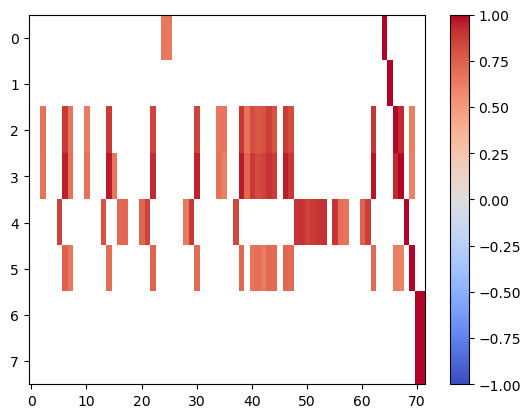

In [9]:
zero_matrix_for_ttest_corr = np.zeros((len(subtracted_redistribution_timeseries_arr), len(subtracted_redistribution_timeseries_arr)))
zero_matrix_for_ttest_pval = np.zeros((len(subtracted_redistribution_timeseries_arr), len(subtracted_redistribution_timeseries_arr)))
for i, pair1 in enumerate(subtracted_redistribution_timeseries_arr):
    for j, pair2 in enumerate(subtracted_redistribution_timeseries_arr):
        single_correlation_distribution, single_p_value_distribution = stats.pearsonr(pair1, pair2)
        zero_matrix_for_ttest_corr[i][j] = single_correlation_distribution
        zero_matrix_for_ttest_pval[i][j] = single_p_value_distribution

zero_matrix_for_ttest_pval_pd, zero_matrix_for_ttest_corr_pd = pd.DataFrame(zero_matrix_for_ttest_pval), pd.DataFrame(zero_matrix_for_ttest_corr)
#zero_matrix_for_ttest_corr_pd = zero_matrix_for_ttest_corr_pd.where(zero_matrix_for_ttest_pval_pd <= .05)
high_corr_values = zero_matrix_for_ttest_corr_pd.tail(8).where(zero_matrix_for_ttest_corr_pd.tail(8) >= .6)
plt.imshow(high_corr_values, aspect='auto', vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()
#low_corr_values = zero_matrix_for_ttest_corr_pd.tail(8).where(zero_matrix_for_ttest_corr_pd.tail(8) <= -.8)
#plt.imshow(low_corr_values, aspect='auto', vmin=-1, vmax=1, cmap='coolwarm')

In [10]:
corr_df_for_keys, tup_ar = pd.DataFrame(high_corr_values), []
for i in corr_df_for_keys:
    for j, nonnan in enumerate(corr_df_for_keys[i].values):
        if not np.isnan(nonnan):
            #print(f'{nonnan} {i}, {j+num_clusters**2}')
            tup_return = [i, j+num_clusters**2]
            tup_ar.append(tup_return)

original_time_series_tobe_dicted = pd.DataFrame(subtracted_redistribution_timeseries_arr)

In [11]:
pdo_tup = []
for it, valuation in enumerate(high_corr_values.loc[66].values):
    if not np.isnan(valuation):
        pdo_tup.append([it, 66])

/vftmp/Theo.Avila/pid27010/ipykernel_61645/730057441.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(10, 5))


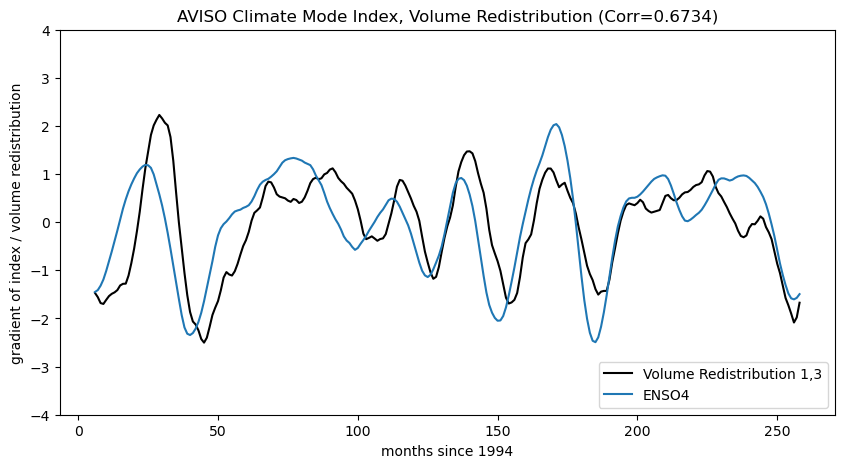

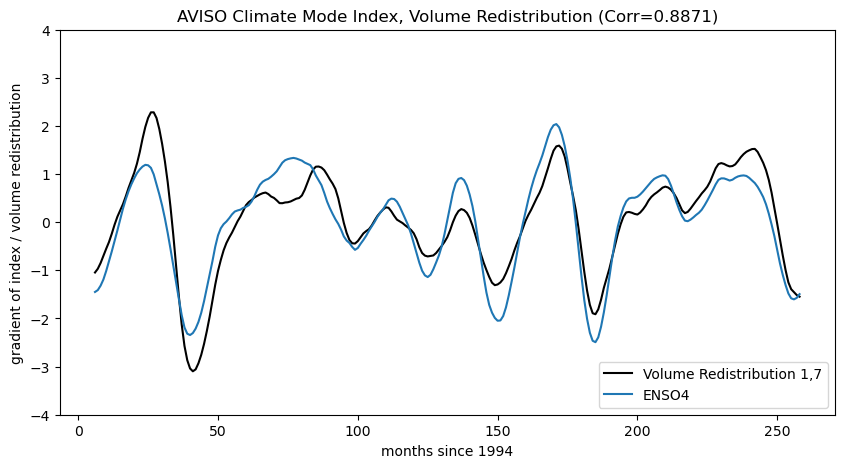

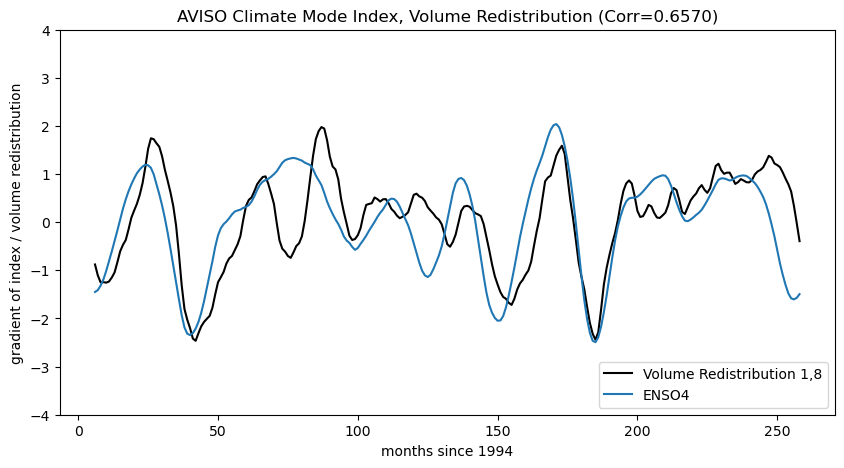

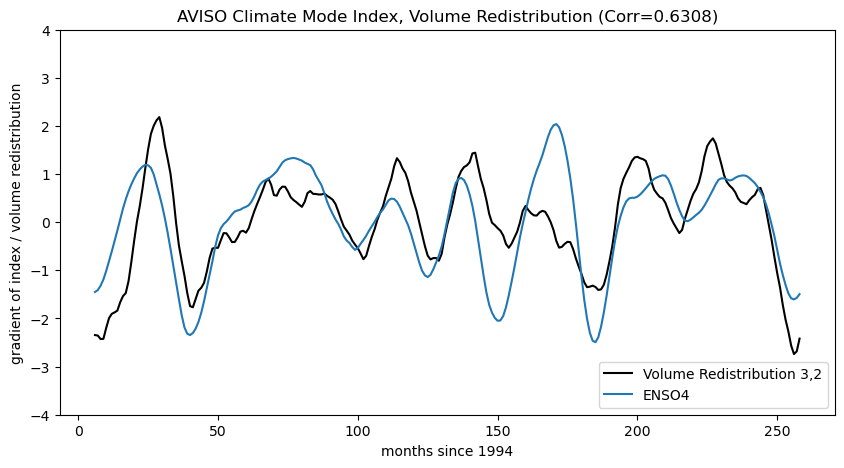

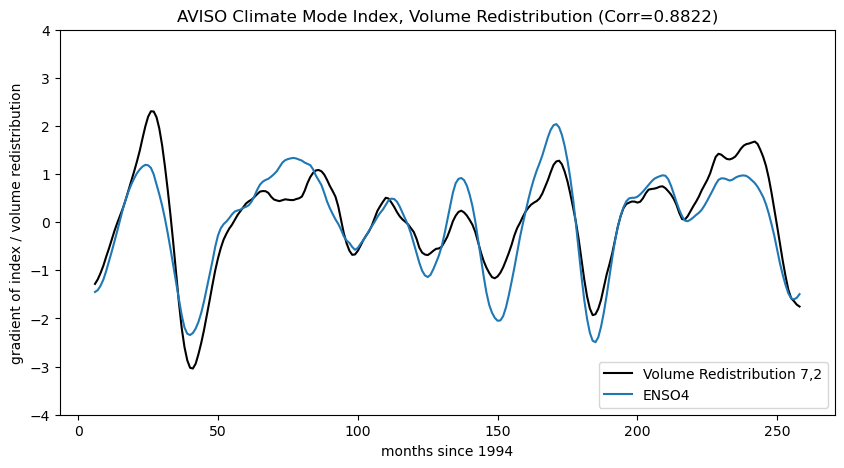

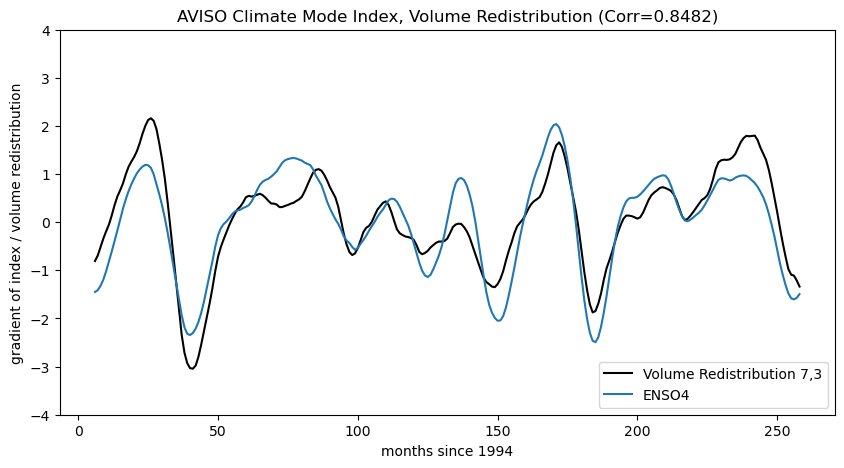

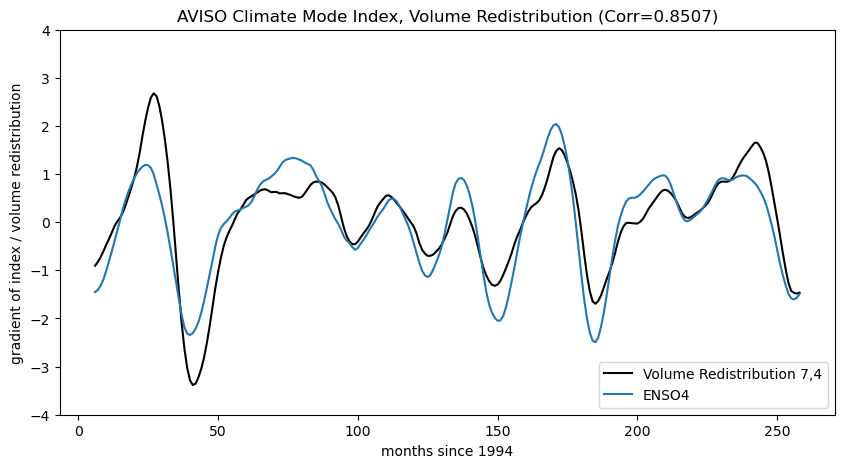

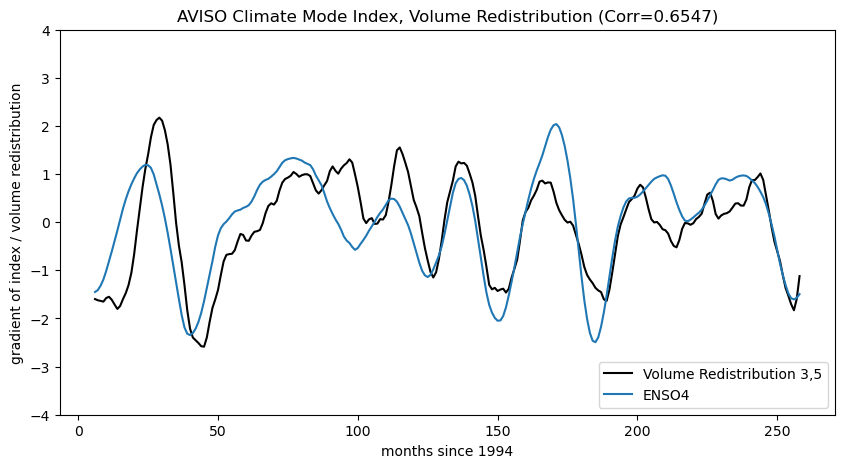

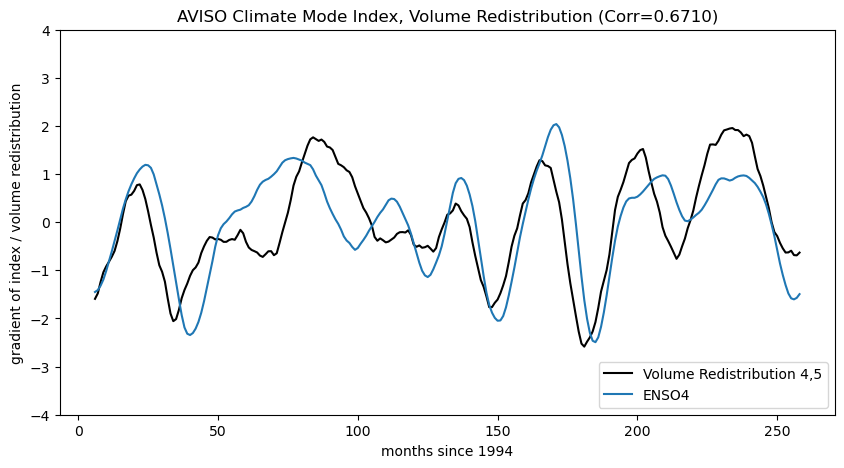

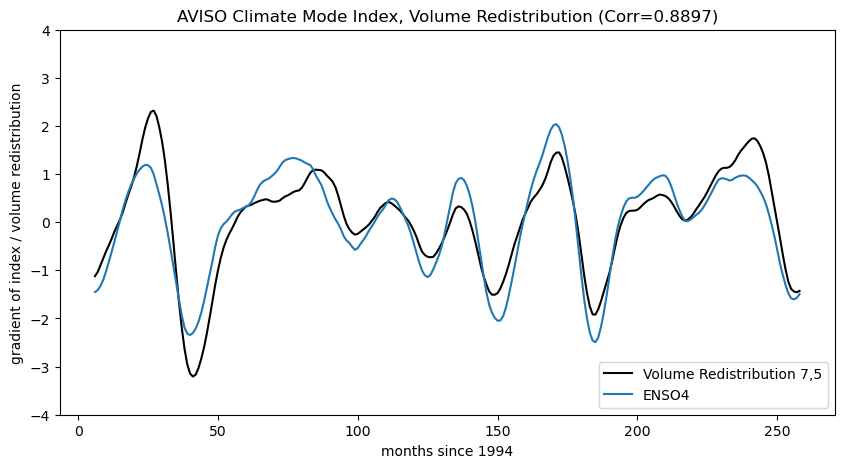

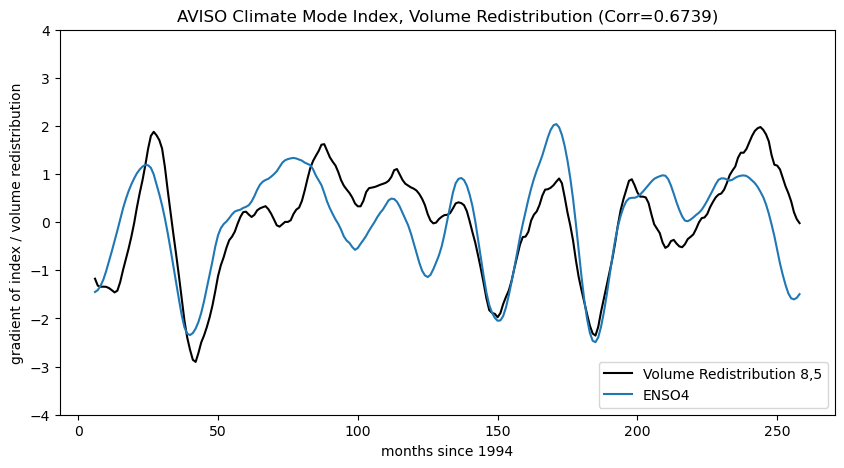

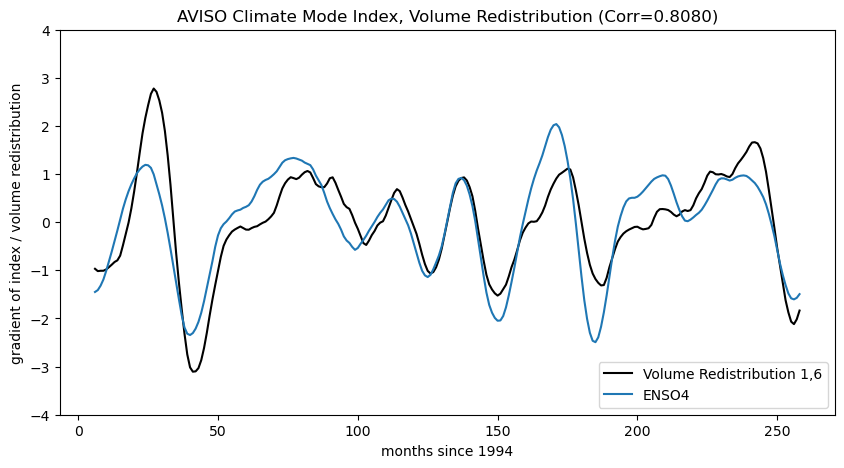

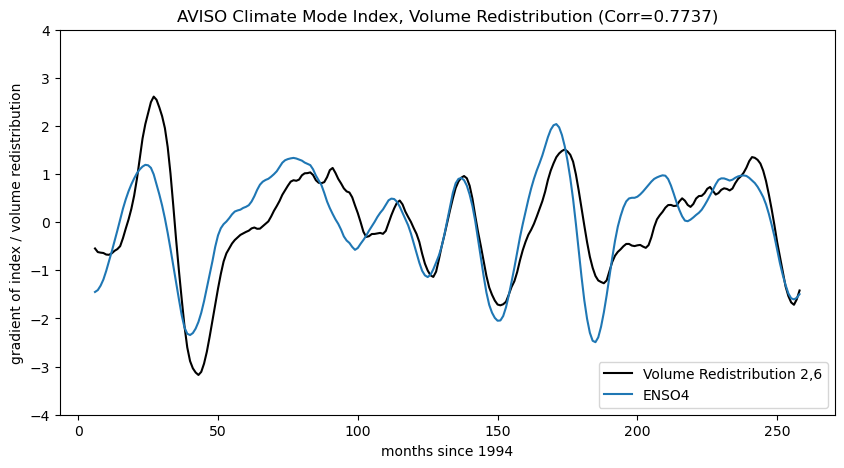

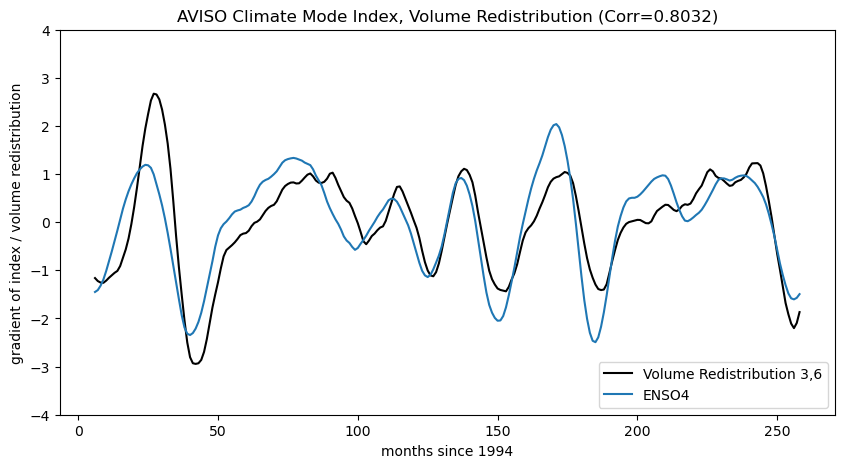

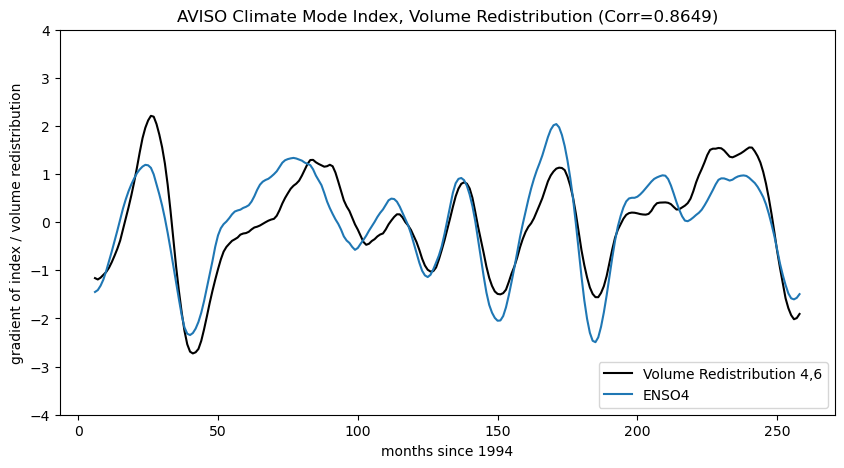

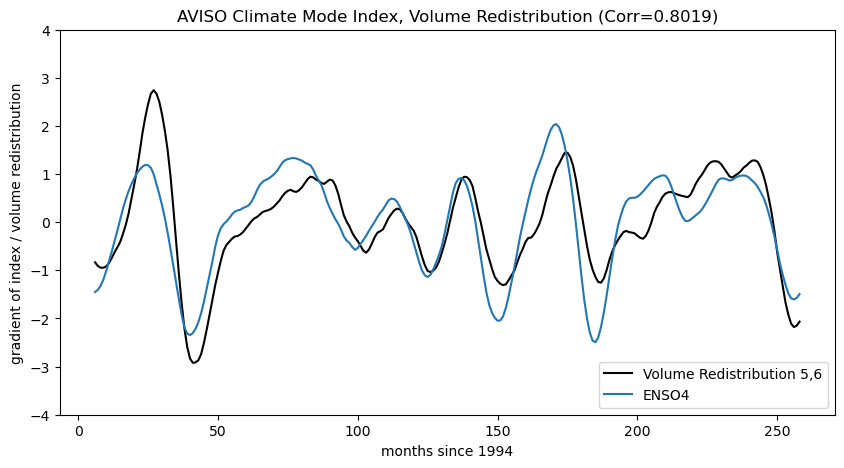

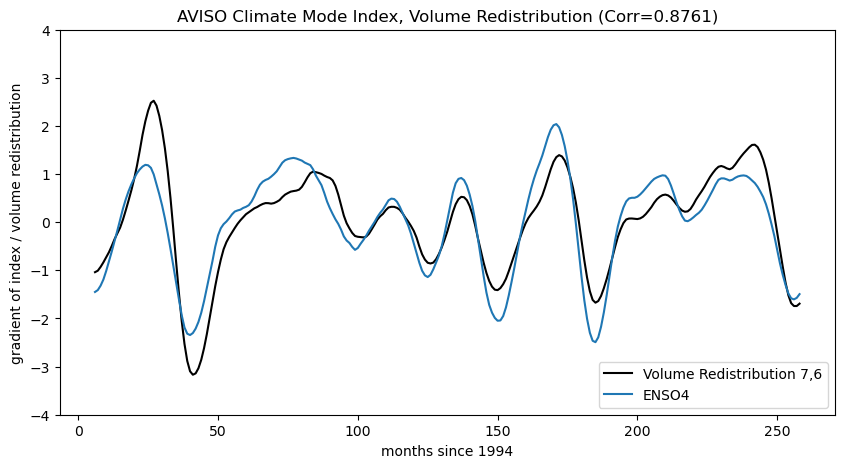

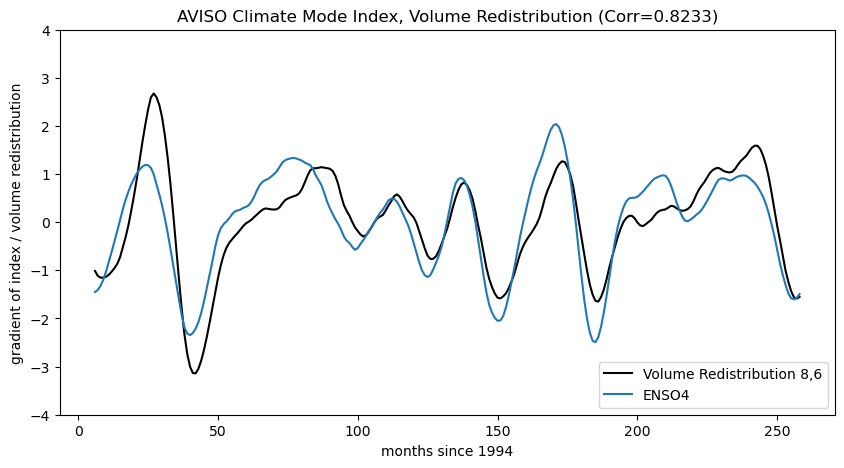

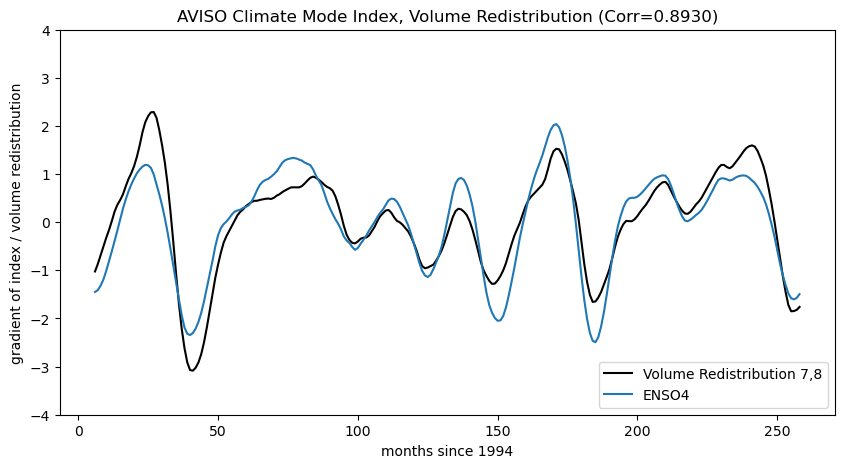

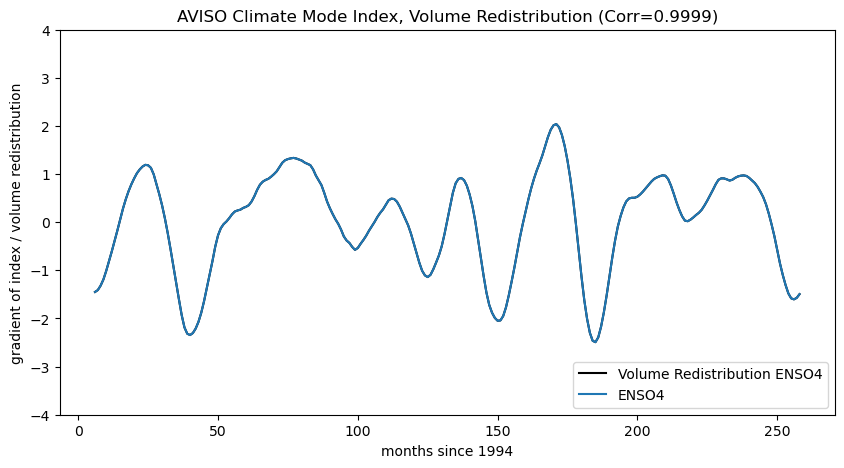

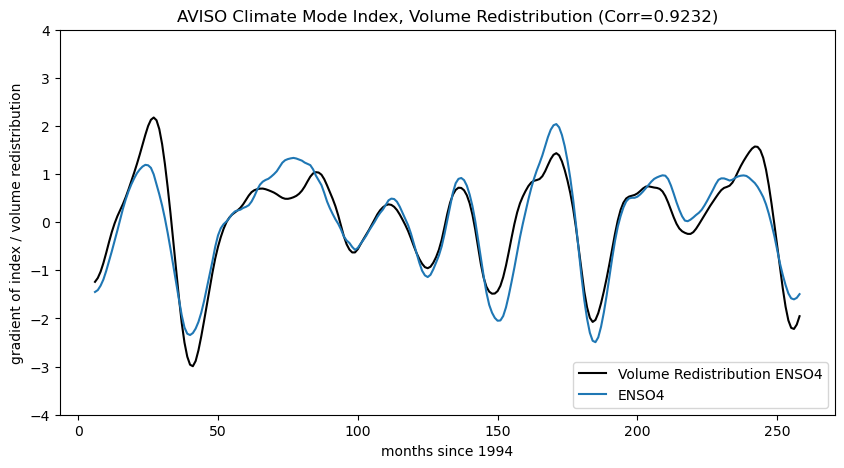

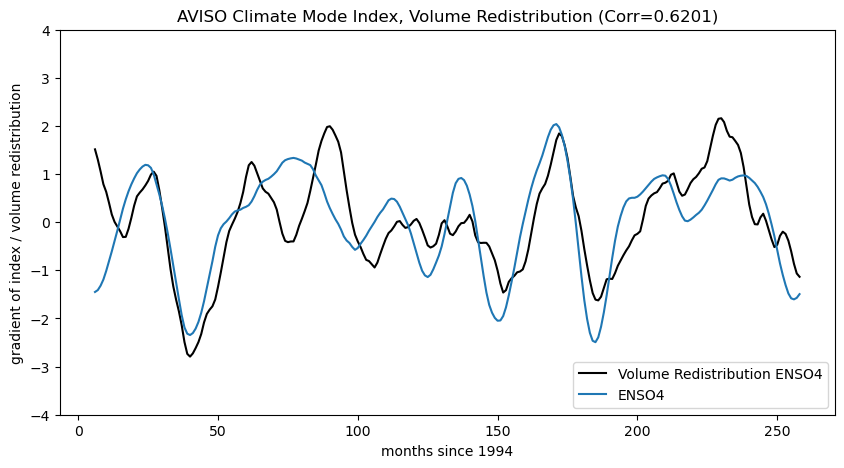

In [12]:
for tuples in pdo_tup:
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    val_minus = tuples[0]
    climate_index = tuples[1]
    
    if val_minus < 64:
        if len(str(val_minus)) == 1:
            volume_redistribution_clusters = f'1,{int(val_minus+1)}'
        else:
            first_cluster = val_minus % num_clusters
            second_cluster = val_minus // num_clusters
            volume_redistribution_clusters = f'{first_cluster+1},{second_cluster+1}'
    elif val_minus >= 64:
        volume_redistribution_clusters = f'{index_names[int(str(climate_index- num_clusters**2)[-1:])].upper()}'
        
    
    
    plt.plot(original_time_series_tobe_dicted.loc[val_minus][6:-41], color='black', label=f'Volume Redistribution {volume_redistribution_clusters}')
    plt.plot(original_time_series_tobe_dicted.loc[climate_index][6:-41], label=f'{index_names[int(str(climate_index- num_clusters**2)[-1:])].upper()}')
    
    plt.legend(loc='lower right')
    corr_ts = str(np.corrcoef(original_time_series_tobe_dicted.loc[val_minus].values, original_time_series_tobe_dicted.loc[climate_index].values)[0][1])[:6]
    
    plt.title(f'AVISO Climate Mode Index, Volume Redistribution (Corr={corr_ts})')
    plt.xlabel(f'months since {start_year}')
    plt.ylabel(f'gradient of index / volume redistribution')
    plt.ylim(-4, 4)
    #plt.savefig(f'aviso_maps/22_all_mode_plots/vol_redist_smooothed_{volume_redistribution_clusters}_{index_names[int(str(climate_index)[-1:])]}_')

0.3704185335061618 at 56


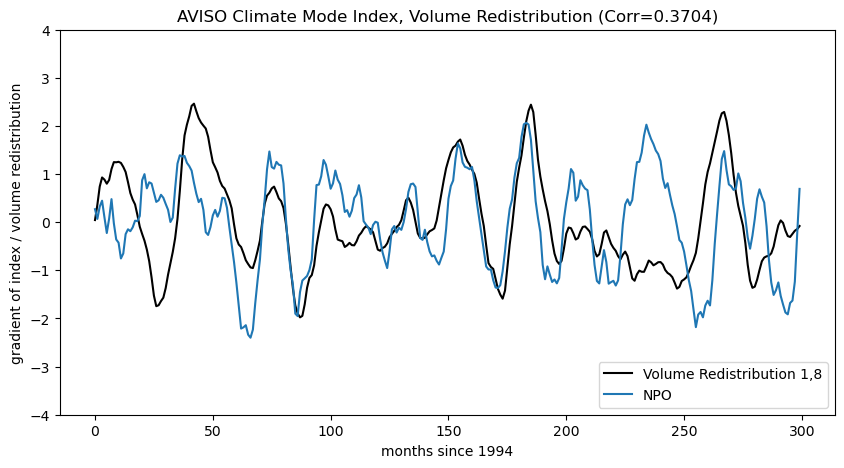

In [69]:
largest_correlation, locator = -1, 0
climate_test = 71
for i in np.arange(0,64):
    largest_val = np.corrcoef(original_time_series_tobe_dicted.loc[i].values, original_time_series_tobe_dicted.loc[climate_test].values)[0][1]
    if i != 24:
        if largest_val >= largest_correlation:
            
            locator = i
            largest_correlation = largest_val

print(f'{largest_correlation} at {locator}')
plot_tup = [[locator, climate_test]]
for tuples in plot_tup:
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    val_minus = tuples[0]
    climate_index = tuples[1]
    
    if val_minus < 64:
        if len(str(val_minus)) == 1:
            volume_redistribution_clusters = f'1,{int(val_minus+1)}'
        else:
            first_cluster = val_minus % num_clusters
            second_cluster = val_minus // num_clusters
            volume_redistribution_clusters = f'{first_cluster+1},{second_cluster+1}'
    elif val_minus >= 64:
        volume_redistribution_clusters = f'{index_names[int(str(climate_index- num_clusters**2)[-1:])].upper()}'
        
    
    
    plt.plot(original_time_series_tobe_dicted.loc[val_minus], color='black', label=f'Volume Redistribution {volume_redistribution_clusters}')
    plt.plot(original_time_series_tobe_dicted.loc[climate_index], label=f'{index_names[int(str(climate_index- num_clusters**2)[-1:])].upper()}')
    
    plt.legend(loc='lower right')
    corr_ts = str(np.corrcoef(original_time_series_tobe_dicted.loc[val_minus].values, original_time_series_tobe_dicted.loc[climate_index].values)[0][1])[:6]
    
    plt.title(f'AVISO Climate Mode Index, Volume Redistribution (Corr={corr_ts})')
    plt.xlabel(f'months since {start_year}')
    plt.ylabel(f'gradient of index / volume redistribution')
    plt.ylim(-4, 4)
    #plt.savefig(f'aviso_maps/22_all_mode_plots/vol_redist_smooothed_{volume_redistribution_clusters}_{index_names[int(str(climate_index)[-1:])]}_')

### Intra Cluster Covariance

In [ ]:
intra_cov_ar = []

for count, inv_cluster_true in enumerate(each_cluster_dataset_true):

    # INtra cluster variance
    inv_cluster_true = inv_cluster_true.zos
    da_flat_cov = inv_cluster_true.stack(location=('latitude', 'longitude')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov = da_flat_cov.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix = da_flattened_cov.to_pandas().T.cov().copy(deep=True)
    
    averaged_for_each_pt_cov = cov_matrix.mean(axis=0).copy(deep=True)
    da_flat_cov.load()
    # Unstack the data
    unstack_data = averaged_for_each_pt_cov.unstack().copy(deep=True)
    
    cluster_intra_cluster_filled = inv_cluster_true.mean(dim='time').copy(deep=True)
    cluster_intra_cluster_filled = cluster_intra_cluster_filled.fillna(np.nan)

    # Inner cluster variance now
    each_cluster_dataset_false[count] = each_cluster_dataset_false[count].zos
    da_flat_cov_false = each_cluster_dataset_false[count].stack(location=('latitude', 'longitude')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov_false = da_flat_cov_false.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix_false = da_flattened_cov_false.to_pandas().T.copy(deep=True)
    da_flat_cov_false.load()
    
    for longitude in unstack_data.columns:
        # Iterate over the index values in "unstack_data"
        print(longitude)
        for latitude in unstack_data.index:
            
            # Access the specific cell in "intra_cov" using index and column values
            unstack_intra_cluster_cov = unstack_data.loc[latitude, longitude]

            unstack_data_values = da_flat_cov.loc[{'latitude': latitude, 'longitude': longitude}].values
            
            cov_matrix_false_copy_for_fill = cov_matrix_false.copy(deep=True)
            cov_matrix_false_copy_for_fill[latitude, longitude] = unstack_data_values
            cov_matrix_false_meaned = cov_matrix_false_copy_for_fill.cov().mean(axis=0)
            resultant_cov_denom_mean = cov_matrix_false_meaned[latitude, longitude]
            cluster_intra_cluster_filled.loc[latitude, longitude] = np.abs(unstack_intra_cluster_cov / resultant_cov_denom_mean)

    
    

    print(count)
    intra_cov_ar.append(cluster_intra_cluster_filled)

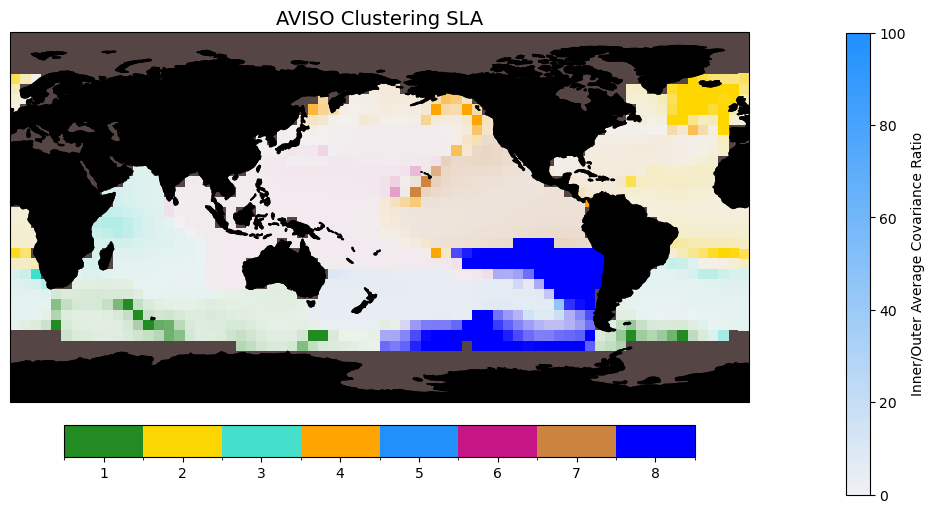

In [519]:

# Plotting the cluster map
center_value_longitude=180
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

vmax_val, vmin_val = 100, 0
for cmap_it, intra_cov in enumerate(intra_cov_ar):
    #intra_cov['longitude'] = intra_cov['longitude'] - 180
    intra_cov.plot(ax=ax, transform=projection, cmap=cmap_ar_div[cmap_it], add_colorbar=False, vmax=vmax_val, vmin=vmin_val)
    #intra_cov['longitude'] = intra_cov['longitude'] + 180

# Add title and extent
ax.set_title(f'AVISO Clustering SLA', fontsize=14)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_ar_div[4], norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05, fraction=0.046)
cbar.set_label('Inner/Outer Average Covariance Ratio')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=.75)
cbar.set_ticks(np.arange(1, num_clusters_range_it + 1))
cbar.set_ticklabels(np.arange(1, num_clusters_range_it + 1))

# Save the figure
plt.savefig(f'aviso_maps/23_cov_bounds_saturation_2100/cov_aviso_sla_norm{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}_intra_inner_cluster_covariance_vmax_{vmax_val}_{vmin_val}_.png')

### Uniform Color Plots

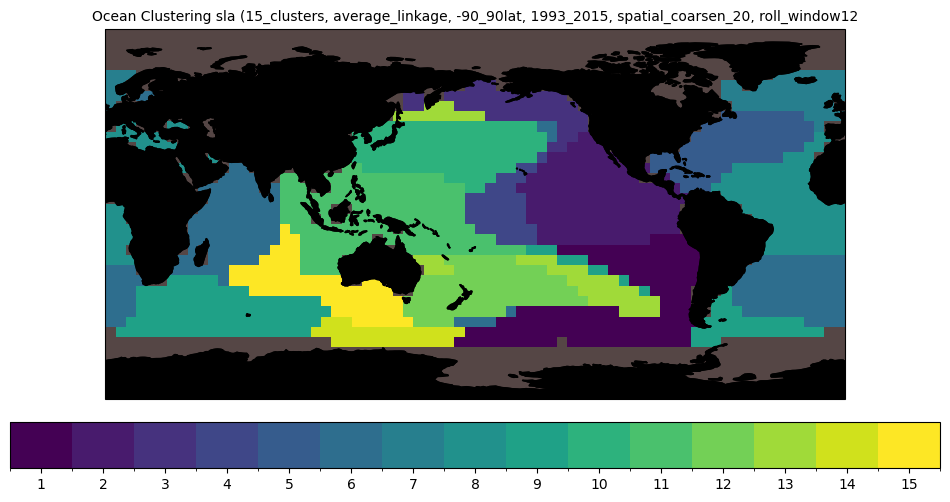

In [216]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
center_value_longitude = 180
sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude

# Define the number of discrete values (clusters) you have

# Create a discrete colormap
cmap = plt.get_cmap('viridis', num_clusters)
bounds = np.arange(1, num_clusters + 2) - .5
norm = BoundaryNorm(bounds, cmap.N)

# Plotting the cluster map
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

# Plot the data
sla_dataset_to_plot.sla.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)

# Add title and extent
ax.set_title(f'Ocean Clustering sla ({num_clusters}_clusters, {linkage_type}_linkage, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spatial_coarsen_{smoothing_std}, roll_window{rolling_window}', fontsize=10)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
cbar.set_ticks(np.arange(1, num_clusters + 1))
cbar.set_ticklabels(np.arange(1, num_clusters + 1))

# Save the figure
plt.savefig(f'aviso_maps/sla_{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}')


### Map of Correlation at some point

In [ ]:
single_value_for_correlation = subset_Coarse_lat_lon_slice_initeration.sel(longitude=200, latitude=0, method='nearest')
fill_corr_map = subset_Coarse_lat_lon_slice_initeration.copy(deep=True)
print(len(subset_Coarse_lat_lon_slice_initeration.longitude))
for i, longitude in enumerate(subset_Coarse_lat_lon_slice_initeration.longitude):
    print(i)
    for latitude in subset_Coarse_lat_lon_slice_initeration.latitude:
        single_correlation = np.corrcoef(single_value_for_correlation, subset_Coarse_lat_lon_slice_initeration.sel(longitude = longitude, latitude = latitude))
        fill_corr_map.loc[dict(longitude=longitude, latitude=latitude)] = single_correlation[0, 1]
single_value_for_correlation = subset_Coarse_lat_lon_slice_initeration.sel(longitude=200, latitude=0, method='nearest')
single_value_for_correlation.plot()

cor_map_2pt5_200 = r.loc[(2.5, 202.5)].to_xarray()
center_value_longitude = 180
cor_map_2pt5_200['longitude'] = cor_map_2pt5_200['longitude'] - center_value_longitude

# Plotting the cluster map
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

cor_map_2pt5_200.plot(ax=ax, transform=projection, cmap='coolwarm', add_colorbar=True, cbar_kwargs={'label': 'Correlation'})

# Add title and extent
ax.set_title('Every Location Correlation with (2.5, 202.5)', fontsize=10)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
#ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

plt.savefig('aviso_maps/0_correlation_single_point_2pt5_202pt5.png')



### Imshow grids

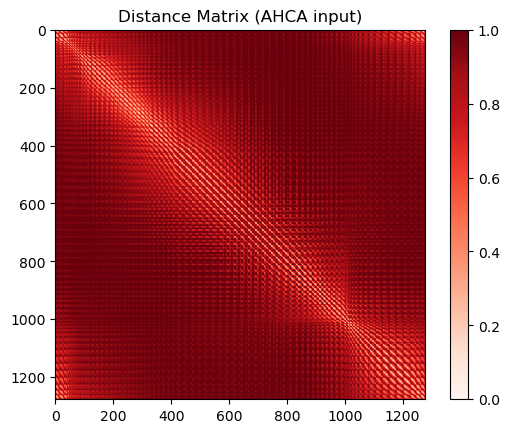

In [155]:
plt.imshow(comparison_matrix, cmap='Reds', vmin=0,vmax=1)
plt.title('Distance Matrix (AHCA input)')
plt.colorbar()
plt.savefig('aviso_maps/1_1_Distance_matrix')

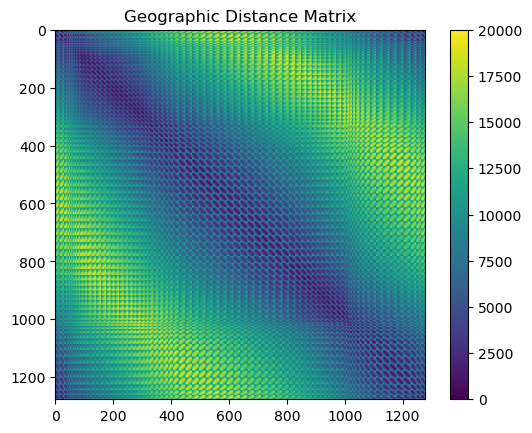

In [156]:
plt.imshow(-geo_distance_matrix, cmap='viridis')
plt.title('Geographic Distance Matrix')
plt.colorbar()
plt.savefig('aviso_maps/1_2_geographic_distance_matrix')

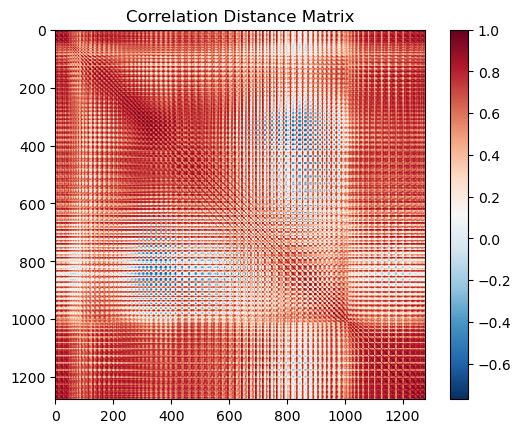

In [157]:
plt.imshow(correlation_matrix, cmap='RdBu_r')
plt.title('Correlation Distance Matrix')
plt.colorbar()
plt.savefig('aviso_maps/1_0_correlation_distance_matrix')

In [142]:
# now are the comparison i.e. the distance matrix of the haversine and other correlation method to show differences? 